**Приблизительный план работы**
* Описание проекта (тема, описание данных, описание полей в данных)
* Предобработка данных (подключение библиотек и данных, поиск дубликатов и пропусков, приведение названий к "змеиному" стилю, объединение данных)
* Исследовательский анализ данных (построение графиков, нахождение аномалий и зависимостей)
* Подготовка данных для обучения модели (кодирование категориальных переменных) 
* Обучения модели (разбиение данных, выбор моделей для обучения, тестовая модель, подбор гиперпараметров) 
* Тест моделей (сравнение моделей, оценка эффективности моделей) 
* Общий вывод
* Отчет

**Цель проекта:** разработать модель, которая сможет предсказать уход клиента.

Уточняющих вопросов нет

# Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

## Описание полей в данных

* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип договора: ежемесячный, годовой и т.д,
* PaperlessBilling – факт выставления счёта на электронную почту,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги,
* Dependents – наличие иждивенцев,
* SeniorCitizen – наличие пенсионного статуса по возрасту,
* Partner – наличие супруга(и),
* MultipleLines – наличие возможности ведения параллельных линий во время звонка.

# Предобработка данных

In [1]:
!pip install phik
!pip install catboost

#подключение необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import pearsonr
from scipy.stats import stats
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


RANDOM_STATE = 30723

     |████████████████████████████████| 679 kB 2.5 MB/s eta 0:00:01


In [2]:
#подключение файлов
try:
    data_contract = pd.read_csv('C:/Users/misha/Downloads/contract_new.csv')
    data_personal = pd.read_csv('C:/Users/misha/Downloads/personal_new.csv')
    data_internet = pd.read_csv('C:/Users/misha/Downloads/internet_new.csv')
    data_phone = pd.read_csv('C:/Users/misha/Downloads/phone_new.csv')
except:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')     

## Contract_new

In [3]:
#просмотр информации о данных
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
#просмотр данных
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Для начала приведем названия столбцов к нижнему регистру и к "змеиному" стилю.

In [5]:
#нижний регистр в названии столбцов
data_contract.columns = data_contract.columns.str.lower()
#приведение к змеиному стилю
data_contract.columns = (['customer_id', 
                          'begin_date',
                         'end_date',
                         'type',
                         'paperless_billing',
                         'payment_method',
                         'monthly_charges',
                         'total_charges'])
#проверка
data_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Теперь переведем тип данных столбцов **begin_date** и **end_date** к datetime.

In [6]:
#перевод к datetime
data_contract['begin_date'] = pd.to_datetime(data_contract['begin_date'], format='%Y-%m-%d')
data_contract['begin_date'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: begin_date, dtype: datetime64[ns]

In [7]:
#просмотр значений end_date
data_contract['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [8]:
#No заменим на 2020-02-01
data_contract['end_date'] = data_contract['end_date'].replace({'No': '2020-02-01'})
#перевод к datetime
data_contract['end_date'] = pd.to_datetime(data_contract['end_date'], format='%Y-%m-%d')

In [9]:
#столбец type
data_contract['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [10]:
#столбец paperless_billing
data_contract['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

In [11]:
#столбец payment_method
data_contract['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [12]:
#столбец monthly_charges
data_contract['monthly_charges'].unique()

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

In [13]:
#столбец total_charges
data_contract['total_charges'].value_counts()

           11
20.45       6
101.0       5
21.53       4
19.65       4
           ..
294.63      1
244.76      1
809.6       1
6082.31     1
3577.8      1
Name: total_charges, Length: 6658, dtype: int64

In [14]:
data_contract.query('total_charges == " "')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


Видим, что есть 11 значений с пробелом. По данным в столбцах **begin_date** и **end_date** видим, что это клиенты со сроком месяц или меньше. Есть смысл поставить в поле **total_charges** значения из **monthly_charges**, а так же привести эти значения к типу float.

In [15]:
#заменим пропуски на значения из monthly_charges
data_contract.loc[data_contract['total_charges'] == ' ', 'total_charges'] = data_contract['monthly_charges']
#столбец total_charges приведем к типу float
data_contract['total_charges'] = data_contract['total_charges'].astype('float')

In [16]:
#проверка
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [17]:
#проверка на дубликаты
data_contract.duplicated().sum()

0

**Вывод:**

* всего 8 столбцов
* пропусков нет, дубликатов нет
* **customer_id** содержит уникальные id клиентов
* **begin_date и end_date** содержат даты. В последнем также есть значение No
* столбцы **monthly_charges и total_charges** должны быть типом float, total_charges имеет несколько значений "пробелов", которые заменяем на значение из **monthly_charges**.

## Personal_new

In [18]:
#просмотр информации о данных
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
#просмотр данных
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Для начала приведем названия столбцов к нижнему регистру и к "змеиному" стилю.

In [20]:
#нижний регистр в названии столбцов
data_personal.columns = data_personal.columns.str.lower()
#приведение к змеиному стилю
data_personal.columns = (['customer_id', 
                          'gender',
                         'senior_citizen',
                         'partner',
                         'dependents'])
#проверка
data_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [21]:
data_personal['customer_id'].unique()

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

In [22]:
data_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [23]:
data_personal['senior_citizen'].unique()

array([0, 1])

Необходимо заменить значения столбца на категориальные признаки как и во всех аналогичных полях.

In [24]:
data_personal['senior_citizen'] = data_personal['senior_citizen'].replace({0: 'No', 1: 'Yes'})

In [25]:
data_personal['partner'].unique()

array(['Yes', 'No'], dtype=object)

In [26]:
data_personal['dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [27]:
#проверка на пропуски
data_personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [28]:
#проверка на дубликаты
data_personal.duplicated().sum()

0

**Вывод:**

* всего 4 столбца
* пропусков нет, дубликатов нет
* столбец **customer_id** содержит уникальные id клиентов
* остальные поля имеют двойные значения.

## Internet_new

In [29]:
#просмотр информации о данных
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [30]:
#просмотр данных
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Для начала приведем названия столбцов к нижнему регистру и к "змеиному" стилю.

In [31]:
#нижний регистр в названии столбцов
data_internet.columns = data_internet.columns.str.lower()
#приведение к змеиному стилю
data_internet.columns = (['customer_id', 
                          'internet_service',
                         'online_security',
                         'online_backup',
                         'device_protection',
                         'tech_support',
                         'streaming_tv',
                         'streaming_movies'])
#проверка
data_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [32]:
data_internet['customer_id'].unique()

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

In [33]:
data_internet['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [34]:
data_internet['online_security'].unique()

array(['No', 'Yes'], dtype=object)

In [35]:
data_internet['online_backup'].unique()

array(['Yes', 'No'], dtype=object)

In [36]:
data_internet['device_protection'].unique()

array(['No', 'Yes'], dtype=object)

In [37]:
data_internet['tech_support'].unique()

array(['No', 'Yes'], dtype=object)

In [38]:
data_internet['streaming_tv'].unique()

array(['No', 'Yes'], dtype=object)

In [39]:
data_internet['streaming_movies'].unique()

array(['No', 'Yes'], dtype=object)

In [40]:
#проверка на пропуски
data_personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [41]:
#проверка на дубликаты
data_personal.duplicated().sum()

0

**Вывод:**

* всего 8 столбцов
* пропусков и дубликатов нет
* столбец **customer_id** содержит уникальные id клиентов
* остальные столбцы имеют двойные значения

## Phone_new

In [42]:
#просмотр информации о данных
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [43]:
#просмотр данных
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Для начала приведем названия столбцов к нижнему регистру и к "змеиному" стилю.

In [44]:
#нижний регистр в названии столбцов
data_phone.columns = data_phone.columns.str.lower()
#приведение к змеиному стилю
data_phone.columns = (['customer_id', 
                          'multiple_lines'])
#проверка
data_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [45]:
data_phone['customer_id'].unique()

array(['5575-GNVDE', '3668-QPYBK', '9237-HQITU', ..., '2234-XADUH',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

In [46]:
data_phone['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

In [47]:
#проверка на пропуски
data_phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

In [48]:
#проверка на дубликаты
data_phone.duplicated().sum()

0

**Вывод:**
* всего 2 столбца
* пропусков и дубликатов нет
* столбец **customer_id** содержит уникальные id клиентов
* **multiple_lines** содержит двойные значения

Теперь займемся объединением всех данных по **customer_id**.

In [49]:
#объединение
data = data_contract.merge(data_personal, how='left', on='customer_id')
data = data.merge(data_internet, how='left', on='customer_id')
data = data.merge(data_phone, how='left', on='customer_id')
data = data.set_index('customer_id')

In [50]:
#просмотр
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

Получилась новая таблица с 18 полями, но теперь с пропусками. Получается, что, если услуга не заказывалась клиентом, то в таблице оставляли пропуск. Нужно эти пустые значения заполнить заглушками. Что и сделаем.

In [51]:
#создание заглушек
data['internet_service'].fillna("No", inplace = True)
data['online_security'].fillna("No", inplace = True)
data['online_backup'].fillna("No", inplace = True)
data['device_protection'].fillna('No', inplace = True)
data['tech_support'].fillna("No", inplace = True)
data['streaming_tv'].fillna("No", inplace = True)
data['streaming_movies'].fillna("No", inplace = True)
data['multiple_lines'].fillna("No", inplace = True)

In [52]:
#проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

**Вывод:**
* все таблицы просмотрены и объединены в общий датасет data
* все названия столбцов приведены к змеиному стилю
* значения столбцов **begin_date** и **end_date** приведены к типу datetime
* значения столбцов **monthly_charges** и **total_charges** приведены к типу float
* пропуски в поле **total_charges** заменены на значения из **monthly_charges**
* No в **end_date** заменены на дату выгрузки 2020.02.01
* все пропуски после объединения заполнены заглушками категориального типа 0-1
* все значения переведены к 0-1

# Исследовательский анализ данных

Приступим к анализу. Необходимо создать целевой признак, а так же признак длительности контракта на основе данных из end_date и begin_date.

In [53]:
#создание целевого признака на основе end_date. 1-клиент ушел, 0-остался
data['left'] = 1
data.loc[data['end_date'] == '2020-02-01', 'left'] = 0

In [54]:
#признак длительности контракта
data['duration_contract'] = (data['end_date'] - data['begin_date']).dt.days

Теперь проанализируем каждый признак подробнее.

## begin_date

Text(0, 0.5, 'Частота появления')

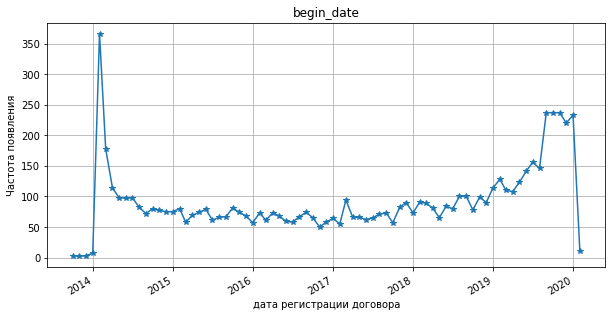

In [55]:
data['begin_date'].value_counts().plot(style='*-', grid=True, figsize=(10,5))
plt.title('begin_date')
plt.xlabel('дата регистрации договора')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

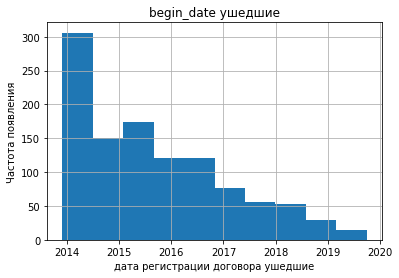

In [56]:
data.query('left == 1')['begin_date'].hist()
plt.title('begin_date ушедшие')
plt.xlabel('дата регистрации договора ушедшие')
plt.ylabel('Частота появления')

**Вывод:** Виден пик в районе 2014 года, после стабильный уровень до начала 2019 года, высокий прирост в 2019-2020. Спад в конце обусловлен ограничением данных датой 2020-02-01. В основном ушли клиенты, заключившие договора в 2014 году (более 300 человек), ближе к концу 2019 года их все меньше.

## end_date

Text(0, 0.5, 'Частота появления')

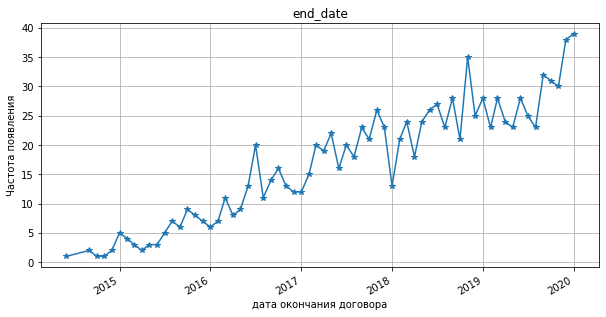

In [57]:
data.query('end_date != "2020-02-01"')['end_date'].value_counts().plot(style='*-', grid=True, figsize=(10,5))
plt.title('end_date')
plt.xlabel('дата окончания договора')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

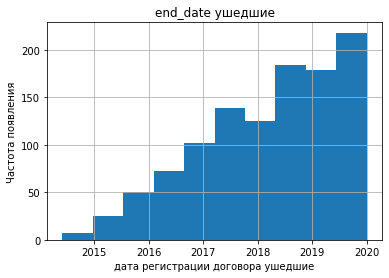

In [58]:
data.query('left == 1 & end_date != "2020-02-01"')['end_date'].hist()
plt.title('end_date ушедшие')
plt.xlabel('дата регистрации договора ушедшие')
plt.ylabel('Частота появления')

**Вывод:** Первый пик ухода приходится на конец 2014- начало 2015 года, второй пик почти в конце 2016 года, третий пик в середине 2017, к концу 2017- началу 2018 года наблюдается минимальный уход клиентов, но под конец 2018 снова возрастание. Можно наблюдать тенденцию к уходу клиентов ближе ко второй половине года- концу. Большая часть ушедших клиентов имела срок окончания договора 2017-2020 года.

## paperless_billing

Text(0, 0.5, 'Частота появления')

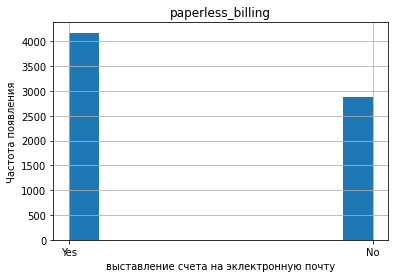

In [59]:
data['paperless_billing'].hist()
plt.title('paperless_billing')
plt.xlabel('выставление счета на эклектронную почту')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

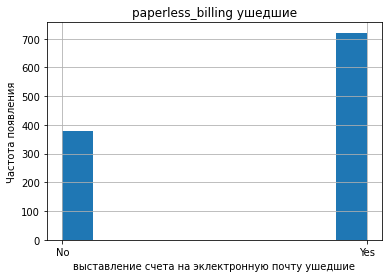

In [60]:
data. query('left == 1')['paperless_billing'].hist()
plt.title('paperless_billing ушедшие')
plt.xlabel('выставление счета на эклектронную почту ушедшие')
plt.ylabel('Частота появления')

**Вывод:** Счет выставляется по почте более чем 4000 клиентов, почти 3000 используют иной способ. Ушли в основном клиенты, использующие эту услугу.

## monthly_charges           

Text(0, 0.5, 'Частота появления')

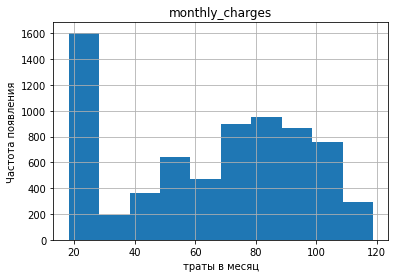

In [61]:
data['monthly_charges'].hist()
plt.title('monthly_charges')
plt.xlabel('траты в месяц')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

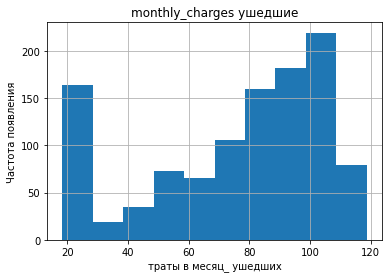

In [62]:
data.query('left == 1')['monthly_charges'].hist()
plt.title('monthly_charges ушедшие')
plt.xlabel('траты в месяц_ ушедших')
plt.ylabel('Частота появления')

**Вывод:** в основном (более 1500) клиенты тратятся не слишком много, основной блок клиентов составляет от 70-120. Ушли клиенты в основном с тратами от 90-110, а так же 10-30 в месяц.

## total_charges

Text(0, 0.5, 'Частота появления')

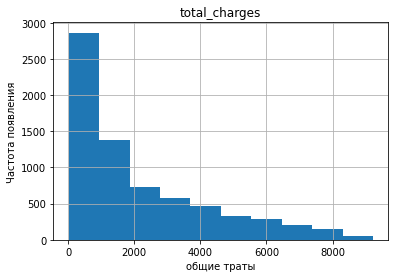

In [63]:
data['total_charges'].hist()
plt.title('total_charges')
plt.xlabel('общие траты')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

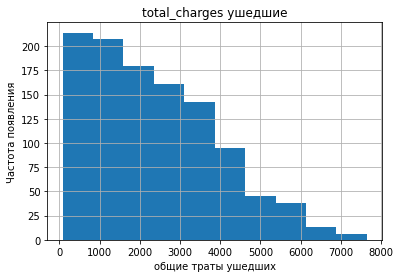

In [64]:
data.query('left == 1')['total_charges'].hist()
plt.title('total_charges ушедшие')
plt.xlabel('общие траты ушедших')
plt.ylabel('Частота появления')

**Вывод:** наибольшее количество клиентов с наименьшими тратами(почти 3000), наименьшее с наибольшими(до 100). Ушли клиенты в основном с общими тратами 1000-4000, наименьшее количество ушо с тратами 6800-7700.

## senior_citizen

Text(0, 0.5, 'Частота появления')

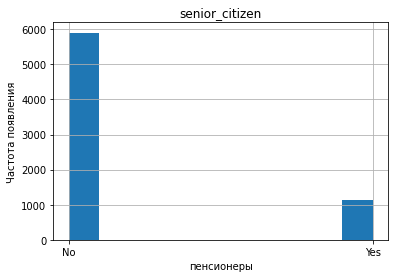

In [65]:
data['senior_citizen'].hist()
plt.title('senior_citizen')
plt.xlabel('пенсионеры')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

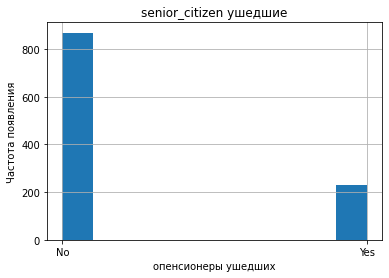

In [66]:
data.query('left == 1')['senior_citizen'].hist()
plt.title('senior_citizen ушедшие')
plt.xlabel('опенсионеры ушедших')
plt.ylabel('Частота появления')

In [67]:
data['senior_citizen'].value_counts()

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

**Вывод:** Пенсионеров 1142, не пенсионеров 5901. В основном ушли не пенсионеры (более 800).

## partner

Text(0, 0.5, 'Частота появления')

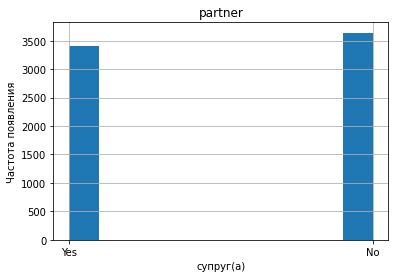

In [68]:
data['partner'].hist()
plt.title('partner')
plt.xlabel('супруг(а)')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

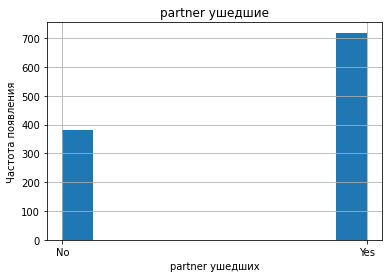

In [69]:
data.query('left == 1')['partner'].hist()
plt.title('partner ушедшие')
plt.xlabel('partner ушедших')
plt.ylabel('Частота появления')

In [70]:
data['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

**Вывод:** количество супружеских пар практически равномерное, 3402 в браке и почти 3641 холостых. Больше ушло семейных пар (более 700).

## dependents

Text(0, 0.5, 'Частота появления')

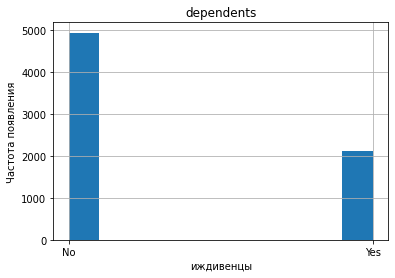

In [71]:
data['dependents'].hist()
plt.title('dependents')
plt.xlabel('иждивенцы')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

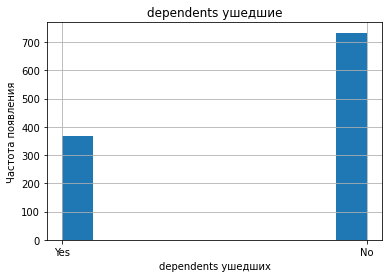

In [72]:
data.query('left == 1')['dependents'].hist()
plt.title('dependents ушедшие')
plt.xlabel('dependents ушедших')
plt.ylabel('Частота появления')

In [73]:
data['dependents'].value_counts()

No     4933
Yes    2110
Name: dependents, dtype: int64

**Вывод:** большая часть живет без иждивенцев 4953, с ними 2110. Ушли в основном люди без иждивенцев(более 700).

## online_security                         

Text(0, 0.5, 'Частота появления')

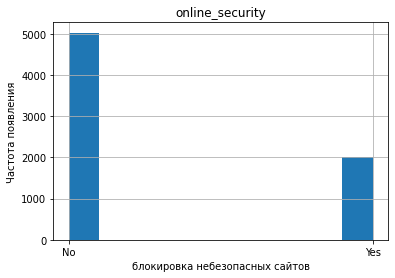

In [74]:
data['online_security'].hist()
plt.title('online_security')
plt.xlabel('блокировка небезопасных сайтов')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

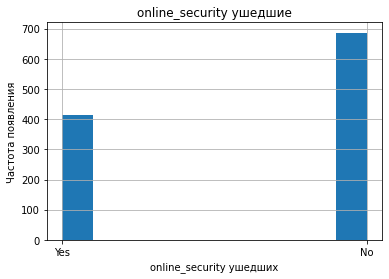

In [75]:
data.query('left == 1')['online_security'].hist()
plt.title('online_security ушедшие')
plt.xlabel('online_security ушедших')
plt.ylabel('Частота появления')

In [76]:
data['online_security'].value_counts()

No     5024
Yes    2019
Name: online_security, dtype: int64

**Вывод:** Услугой **online_security** (блокировка небезопасных сайтов) пользуется 2019 человек против 5024. Ушедшие клиенты в основом не пользовались услугой (более 600).

## online_backup                           

Text(0, 0.5, 'Частота появления')

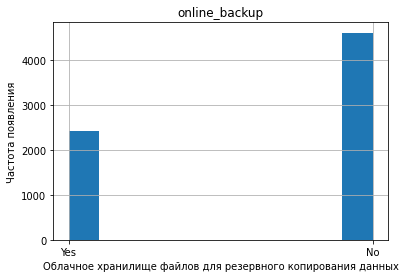

In [77]:
data['online_backup'].hist()
plt.title('online_backup')
plt.xlabel('Облачное хранилище файлов для резервного копирования данных')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

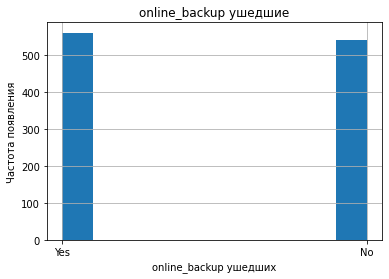

In [78]:
data.query('left == 1')['online_backup'].hist()
plt.title('online_backup ушедшие')
plt.xlabel('online_backup ушедших')
plt.ylabel('Частота появления')

In [79]:
data['online_backup'].value_counts()

No     4614
Yes    2429
Name: online_backup, dtype: int64

**Вывод:** Услугой **online_backup** (Облачное хранилище файлов для резервного копирования данных) пользуется 2429 против 4614. Ушло клиентов, пользующихся в равной степени услугой.

## device_protection                       

Text(0, 0.5, 'Частота появления')

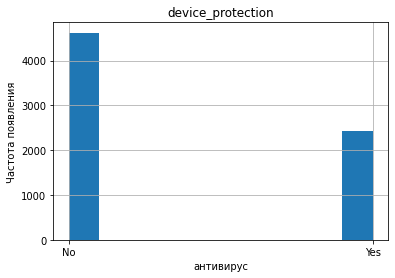

In [80]:
data['device_protection'].hist()
plt.title('device_protection')
plt.xlabel('антивирус')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

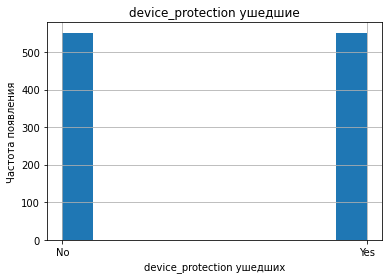

In [81]:
data.query('left == 1')['device_protection'].hist()
plt.title('device_protection ушедшие')
plt.xlabel('device_protection ушедших')
plt.ylabel('Частота появления')

In [82]:
data['device_protection'].value_counts()

No     4621
Yes    2422
Name: device_protection, dtype: int64

**Вывод:** Услугой **device_protection** (антивирус) пользуются 2422 против 4621. Ушло равное количество клиентов, пользующихся услугой.

## tech_support                            

Text(0, 0.5, 'Частота появления')

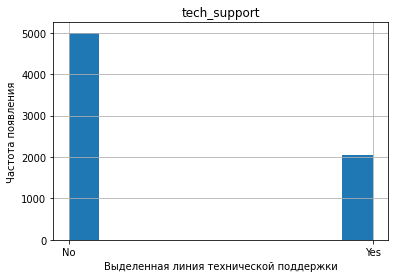

In [83]:
data['tech_support'].hist()
plt.title('tech_support')
plt.xlabel('Выделенная линия технической поддержки')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

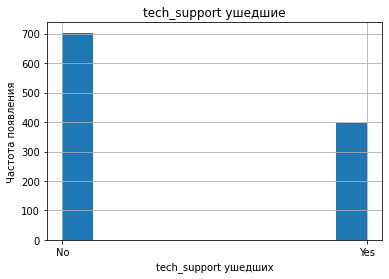

In [84]:
data.query('left == 1')['tech_support'].hist()
plt.title('tech_support ушедшие')
plt.xlabel('tech_support ушедших')
plt.ylabel('Частота появления')

In [85]:
data['tech_support'].value_counts()

No     4999
Yes    2044
Name: tech_support, dtype: int64

**Вывод:** Услугой **tech_support** (Выделенная линия технической поддержки) пользуются 2044 против 4999. Ушедшие клиенты в основном не пользовались данной услугой (400 человек против 700)

## streaming_tv                            

Text(0, 0.5, 'Частота появления')

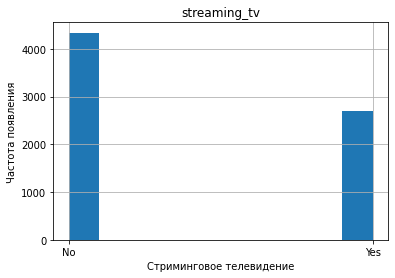

In [86]:
data['streaming_tv'].hist()
plt.title('streaming_tv')
plt.xlabel('Стриминговое телевидение')
plt.ylabel('Частота появления')

In [87]:
data['streaming_tv'].value_counts()

No     4336
Yes    2707
Name: streaming_tv, dtype: int64

**Вывод:** Услугой **streaming_tv** (Стриминговое телевидение) пользуются 2707 против 4336

## streaming_movies                        

Text(0, 0.5, 'Частота появления')

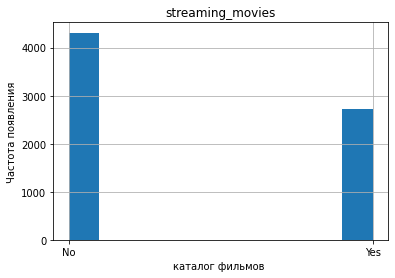

In [88]:
data['streaming_movies'].hist()
plt.title('streaming_movies')
plt.xlabel('каталог фильмов ')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

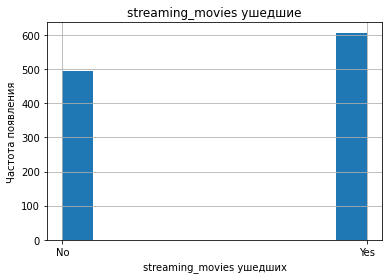

In [89]:
data.query('left == 1')['streaming_movies'].hist()
plt.title('streaming_movies ушедшие')
plt.xlabel('streaming_movies ушедших')
plt.ylabel('Частота появления')

In [90]:
data['streaming_movies'].value_counts()

No     4311
Yes    2732
Name: streaming_movies, dtype: int64

**Вывод:** Услугой **streaming_movies** (каталог фильмов) пользуются 2732 против 4311. Ушедшие клиенты пользовались данной услугой практически в равной степени (чуть более 600 против почти 500)

## multiple_lines                          

Text(0, 0.5, 'Частота появления')

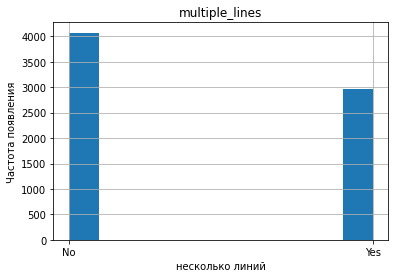

In [91]:
data['multiple_lines'].hist()
plt.title('multiple_lines')
plt.xlabel('несколько линий')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

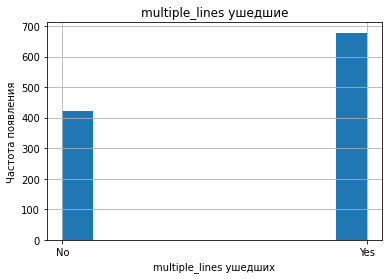

In [92]:
data.query('left == 1')['multiple_lines'].hist()
plt.title('multiple_lines ушедшие')
plt.xlabel('multiple_lines ушедших')
plt.ylabel('Частота появления')

In [93]:
data['multiple_lines'].value_counts()

No     4072
Yes    2971
Name: multiple_lines, dtype: int64

**Вывод:** Услугой **multiple_lines** (несколько линий) пользуются 2971 против 4072. Ушедшие клиенты в основном пользовались данной услугой (почти 700 против чуть более 400)

## type

Text(0, 0.5, 'Частота появления')

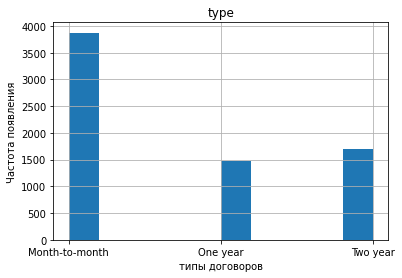

In [94]:
data['type'].hist()
plt.title('type')
plt.xlabel('типы договоров')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

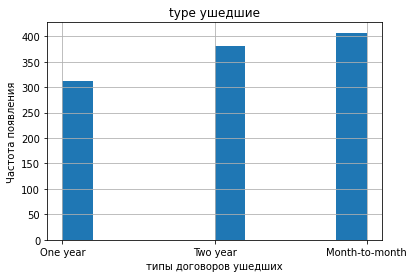

In [95]:
data.query('left == 1')['type'].hist()
plt.title('type ушедшие')
plt.xlabel('типы договоров ушедших')
plt.ylabel('Частота появления')

In [96]:
data['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

**Вывод:** Клиенты больше всего используют помесечный тип договора 3875, потом 2-годичный 1695 и 1-годичный 1473. В основном ушли клиенты с помесячной оплатой (чуть более 400), 2-летней (почти 400) и 1-летней (чуть более 300)

## internet_service

Text(0, 0.5, 'Частота появления')

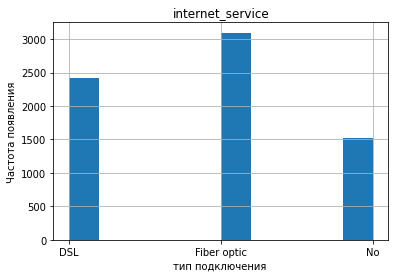

In [97]:
data['internet_service'].hist()
plt.title('internet_service')
plt.xlabel('тип подключения ')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

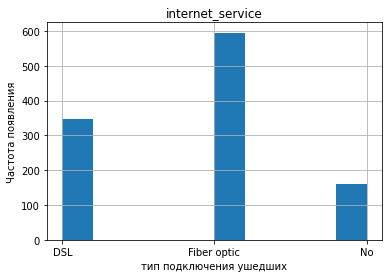

In [98]:
data.query('left == 1')['internet_service'].hist()
plt.title('internet_service')
plt.xlabel('тип подключения ушедших')
plt.ylabel('Частота появления')

In [99]:
data['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: internet_service, dtype: int64

**Вывод:** Больше всего клиенты пользуются оптоволокном 3096, потом телефонной линией 2421, а 1526 вообще не пользуются услугой. Большая часть ушла клиентов оптоволокна( почти 600), телефонной линии(более 300), не пользовались услугой почти 200 ушедших.

## payment_method

Text(0, 0.5, 'Частота появления')

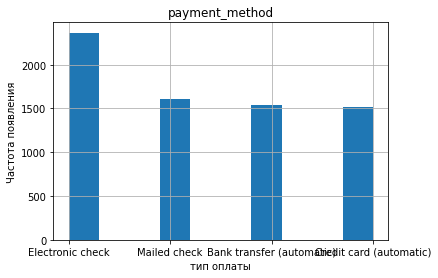

In [100]:
data['payment_method'].hist()
plt.title('payment_method')
plt.xlabel('тип оплаты')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

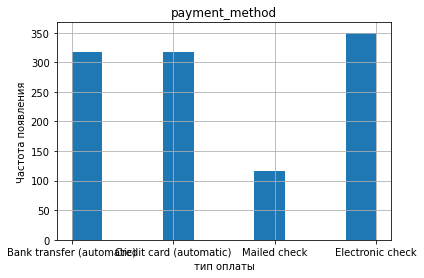

In [101]:
data.query('left == 1')['payment_method'].hist()
plt.title('payment_method')
plt.xlabel('тип оплаты')
plt.ylabel('Частота появления')

In [102]:
data['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

**Вывод:** По типу платежа следующее распределение: Electronic check 2365, Mailed check 1612, Bank transfer (automatic) 1544, Credit card (automatic) 1522. В основном ушли Electronic check 350, Bank и Credit Card 320, Mailed check 120

## gender

Text(0, 0.5, 'Частота появления')

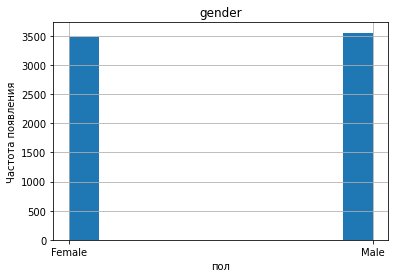

In [103]:
data['gender'].hist()
plt.title('gender')
plt.xlabel('пол')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

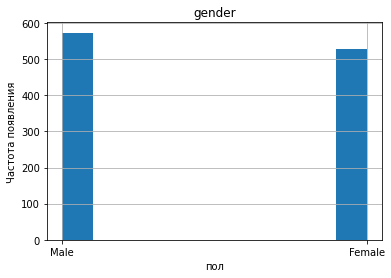

In [104]:
data.query('left == 1')['gender'].hist()
plt.title('gender')
plt.xlabel('пол')
plt.ylabel('Частота появления')

In [105]:
data['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

**Вывод:** По половой принадлежности распределение практически одинаковое. 3555 мужчин против 3488 женщин. Ушли практически в равной степени клиенты мужского(почти 600) и женского(чуть более 500) пола.

## left

Text(0, 0.5, 'Частота появления')

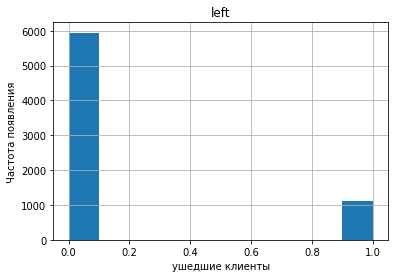

In [106]:
data['left'].hist()
plt.title('left')
plt.xlabel('ушедшие клиенты')
plt.ylabel('Частота появления')

In [107]:
data['left'].value_counts()

0    5942
1    1101
Name: left, dtype: int64

**Вывод:** Ушедших клиентов небольшое количество 1101 против 5942 оставшихся

## duration_contract

Text(0, 0.5, 'Частота появления')

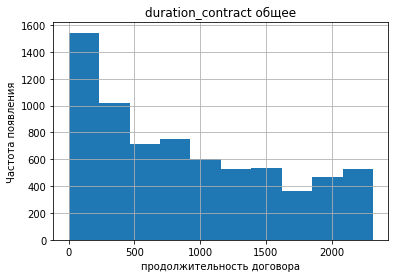

In [108]:
data['duration_contract'].hist()
plt.title('duration_contract общее')
plt.xlabel('продолжительность договора')
plt.ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

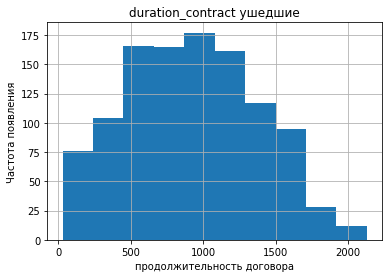

In [109]:
data.query('left == 1 ')['duration_contract'].hist()
plt.title('duration_contract ушедшие')
plt.xlabel('продолжительность договора')
plt.ylabel('Частота появления')

**Вывод:** В основном ушедшие клиенты пользовались услугами компании от 500-1500 дней.

## Общий вывод по блоку

* почти 60% клиентов получают счет по электронной почте
* 16% пенсионеров, 48% имеют партнера, почти 30% имеют иждивенцев
* 28,6% используют блокировку опасных сайтов(online_security), 34,5% используют облачное хранилище(online_backup), 34,4% пользуются антивирусом(device_protection), 29% используют выделенную линию техподдержки(tech_support), 38,8% используют стриминговое телевидение(streaming_tv), 38,4% пользуются каталогом фильмов(streaming_movies), 42% используют параллельные вызовы во время разговора(multiple_lines)
* телефонной линией пользуются 34,3%, оптоволокном 43,9%
* почти 21% пользуются годичным договором, 24% двугодичным
* 21,6% оплачивают кредиткой, 22,8% чек по почте, 33,5% электронным чеком
* равное количество мужчин и женщин
* расторгло договор с компанией около 15,6% клиентов

* Begin_date. Виден пик в районе 2014 года, после стабильный уровень до начала 2019 года, высокий прирост в 2019-2020. Спад в конце обусловлен ограничением данных датой 2020-02-01. В основном ушли клиенты, заключившие договора в 2014 году (более 300 человек), ближе к концу 2019 года их все меньше
* End_date. Первый пик ухода приходится на конец 2014- начало 2015 года, второй пик почти в конце 2016 года, третий пик в середине 2017, к концу 2017- началу 2018 года наблюдается минимальный уход клиентов, но под конец 2018 снова возрастание. Можно наблюдать тенденцию к уходу клиентов ближе ко второй половине года- концу. Большая часть ушедших клиентов имела срок окончания договора 2017-2020 года.
* Счет выставляется по почте более чем 4000 клиентов, почти 3000 используют иной способ. Ушли в основном клиенты, использующие эту услугу.
* в основном (более 1500) клиенты тратятся не слишком много, основной блок клиентов составляет от 70-120. Ушли клиенты в основном с тратами от 90-110, а так же 10-30 в месяц
* наибольшее количество клиентов с наименьшими тратами(почти 3000), наименьшее с наибольшими(до 100). Ушли клиенты в основном с общими тратами 1000-4000, наименьшее количество ушо с тратами 6800-7700.
* Пенсионеров 1142, не пенсионеров 5901. В основном ушли не пенсионеры (более 800).
* большая часть живет без иждивенцев 4953, с ними 2110. Ушли в основном люди без иждивенцев(более 700).
* Услугой **online_security** (блокировка небезопасных сайтов) пользуется 2019 человек против 5024. Ушедшие клиенты в основом не пользовались услугой (более 600).
* Услугой **online_backup** (Облачное хранилище файлов для резервного копирования данных) пользуется 2429 против 4614. Ушло клиентов, пользующихся в равной степени услугой.
* Услугой **device_protection** (антивирус) пользуются 2422 против 4621. Ушло равное количество клиентов, пользующихся услугой.
* Услугой **tech_support** (Выделенная линия технической поддержки) пользуются 2044 против 4999. Ушедшие клиенты в основном не пользовались данной услугой (400 человек против 700)
* Услугой **streaming_movies** (каталог фильмов) пользуются 2732 против 4311. Ушедшие клиенты пользовались данной услугой практически в равной степени (чуть более 600 против почти 500)
* Услугой **multiple_lines** (несколько линий) пользуются 2971 против 4072. Ушедшие клиенты в основном пользовались данной услугой (почти 700 против чуть более 400)
* Клиенты больше всего используют помесечный тип договора 3875, потом 2-годичный 1695 и 1-годичный 1473. В основном ушли клиенты с помесячной оплатой (чуть более 400), 2-летней (почти 400) и 1-летней (чуть более 300)
* Больше всего клиенты пользуются оптоволокном 3096, потом телефонной линией 2421, а 1526 вообще не пользуются услугой. Большая часть ушла клиентов оптоволокна( почти 600), телефонной линии(более 300), не пользовались услугой почти 200 ушедших.
* По типу платежа следующее распределение: Electronic check 2365, Mailed check 1612, Bank transfer (automatic) 1544, Credit card (automatic) 1522. В основном ушли Electronic check 350, Bank и Credit Card 320, Mailed check 120
* По половой принадлежности распределение практически одинаковое. 3555 мужчин против 3488 женщин. Ушли практически в равной степени клиенты мужского(почти 600) и женского(чуть более 500) пола.
* Ушедших клиентов небольшое количество 1101 против 5942 оставшихся
* В основном ушедшие клиенты пользовались услугами компании от 500-1500 дней.

# Обучение моделей

## Подготовка данных  к обучению

Для начала уберем из набора данных конфликтующие столбцы end_date, begin_date с duration_contract.

In [110]:
#сделаем копию датасета
data_b = data
data_b.drop('end_date', axis = 1, inplace = True)
data_b.drop('begin_date', axis = 1, inplace = True)

Проверим целевой признак на наличие дисбаланса

In [111]:
data_b['left'].value_counts()

0    5942
1    1101
Name: left, dtype: int64

Дисбаланс наблюдается.

Посмотрим на коррелляцию.

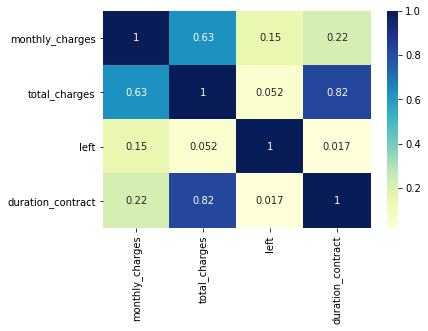

In [112]:
#корреляция
data_b_corr = sns.heatmap(data_b.corr(), cmap="YlGnBu", annot=True)

Основная часть данных имеет минимальную зависимость. Сильная зависимость у duration_contract и total_charges. Чем дольше клиент пользуется услугами тем больше денег он тратит.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'left', 'duration_contract']


<AxesSubplot:>

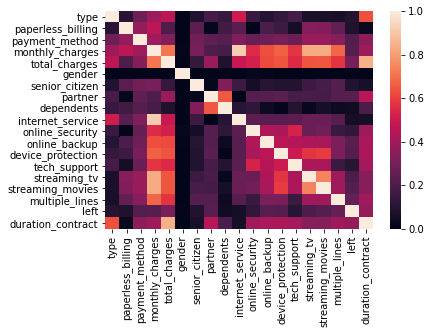

In [113]:
#корреляция категориальных признаков
sns.heatmap(data_b.phik_matrix())

Необходимо перевести бинарные категориальные переменные к значениям 1 и 0.

In [114]:
data_b.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration_contract
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


In [115]:
#перевод признаков
data_b['paperless_billing'] = pd.Series(np.where(data['paperless_billing'].values == 'Yes', 1, 0), data.index)
data_b['senior_citizen'] = pd.Series(np.where(data['senior_citizen'].values == 'Yes', 1, 0), data.index)
data_b['partner'] = pd.Series(np.where(data['partner'].values == 'Yes', 1, 0), data.index)
data_b['online_security'] = pd.Series(np.where(data['online_security'].values == 'Yes', 1, 0), data.index)
data_b['online_backup'] = pd.Series(np.where(data['online_backup'].values == 'Yes', 1, 0), data.index)
data_b['device_protection'] = pd.Series(np.where(data['device_protection'].values == 'Yes', 1, 0), data.index)
data_b['tech_support'] = pd.Series(np.where(data['tech_support'].values == 'Yes', 1, 0), data.index)
data_b['streaming_tv'] = pd.Series(np.where(data['streaming_tv'].values == 'Yes', 1, 0), data.index)
data_b['streaming_movies'] = pd.Series(np.where(data['streaming_movies'].values == 'Yes', 1, 0), data.index)
data_b['multiple_lines'] = pd.Series(np.where(data['multiple_lines'].values == 'Yes', 1, 0), data.index)
data_b['gender'] = pd.Series(np.where(data['gender'].values == 'Female', 1, 0), data.index)
data_b['dependents'] = pd.Series(np.where(data['dependents'].values == 'Yes', 1, 0), data.index)

In [116]:
#проверка
data_b.head(1)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration_contract
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,31.04,1,0,1,0,DSL,0,1,0,0,0,0,0,0,31


Теперь разделим данные на train и test(0.25), выделим признаки и целевой признак, поделим выборки на OHE и scaler для логистической регрессии.

In [117]:
#разделение на выборки
data_b_train, data_b_test = train_test_split(data_b, test_size = 0.25, random_state = RANDOM_STATE)

In [122]:
#определение признаков
b_features_train = data_b_train.drop('left', axis = 1)
b_features_test = data_b_test.drop('left', axis = 1)

b_target_train = data_b_train['left']
b_target_test = data_b_test['left']

#ohe
b_features_train_ohe = pd.get_dummies(b_features_train, columns = ['type', 'internet_service','payment_method'], drop_first = True)
b_features_test_ohe = pd.get_dummies(b_features_test, columns = ['type', 'internet_service','payment_method'], drop_first = True)

#создание численных признаков для масштабирования
numeric = ['monthly_charges', 'total_charges','duration_contract']

#scaler для логичстическоей регрессии.
scaler = StandardScaler()
scaler.fit(b_features_train_ohe[numeric])

b_features_train_scaled = scaler.transform(b_features_train_ohe[numeric])
b_features_test_scaled = scaler.transform(b_features_test_ohe[numeric])

b_features_train.shape, b_features_test.shape, b_target_train.shape, b_target_test.shape

((5282, 18), (1761, 18), (5282,), (1761,))

## Выводы

* Были убраны из набора данных конфликтующие столбцы end_date, begin_date с duration_contract
* Был найден дисбаланс целевого признака
* Основная часть данных имеет минимальную зависимость. Сильная зависимость у duration_contract и total_charges. Чем дольше клиент пользуется услугами тем больше денег он тратит.
* переведены бинарные категориальные переменные к значениям 1 и 0
* Для оставшихся признаков был применен метод OHE
* Данные были поделены на train и test(0.25).

## Обучение моделей

### CatBoostClassifier

Обучим модель и посмотрим метрику.

In [120]:
%%time

model_cat = CatBoostClassifier(random_state=RANDOM_STATE)
param_cat = {'depth' : [6, 7, 8], 
         'learning_rate': [0.3, 0.5, 0.8], 
         'iterations': [35, 50, 70]}

gs_cat = GridSearchCV(model_cat, param_grid=param_cat, cv=3, scoring='roc_auc')
gs_cat.fit(b_features_train_ohe, b_target_train, verbose=True, plot=False)
print(gs_cat.best_estimator_)
print(gs_cat.best_score_)
print(gs_cat.best_params_)

0:	learn: 0.5073089	total: 49.9ms	remaining: 1.7s
1:	learn: 0.4226667	total: 52.5ms	remaining: 866ms
2:	learn: 0.3689444	total: 55.1ms	remaining: 588ms
3:	learn: 0.3435397	total: 57.9ms	remaining: 449ms
4:	learn: 0.3304795	total: 60.5ms	remaining: 363ms
5:	learn: 0.3199244	total: 63ms	remaining: 304ms
6:	learn: 0.3142860	total: 65.5ms	remaining: 262ms
7:	learn: 0.3070517	total: 68.1ms	remaining: 230ms
8:	learn: 0.3019791	total: 70.6ms	remaining: 204ms
9:	learn: 0.2983085	total: 72.9ms	remaining: 182ms
10:	learn: 0.2948414	total: 75.4ms	remaining: 164ms
11:	learn: 0.2912658	total: 77.9ms	remaining: 149ms
12:	learn: 0.2881786	total: 80.3ms	remaining: 136ms
13:	learn: 0.2864536	total: 82.7ms	remaining: 124ms
14:	learn: 0.2837265	total: 85.1ms	remaining: 113ms
15:	learn: 0.2808907	total: 87.5ms	remaining: 104ms
16:	learn: 0.2787122	total: 89.8ms	remaining: 95.1ms
17:	learn: 0.2753392	total: 92.1ms	remaining: 87ms
18:	learn: 0.2721619	total: 94.5ms	remaining: 79.6ms
19:	learn: 0.2691884	tot

**Вывод:** CatBoostClassifier ('depth': 6, 'iterations': 70, 'learning_rate': 0.5, random_state=30723) показал ROC-AUC = 0.8662070945579403

### RandomForestClassifier

In [121]:
%%time

model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
param_forest = {'max_depth' : [6,10, 15], 
        'n_estimators': [100, 200, 500],
        'min_samples_split': [8, 10, 15],
        'min_samples_leaf' : [2,3,4]}

gs_forest = GridSearchCV(estimator=model_forest, param_grid=param_forest, cv=5, scoring='roc_auc', verbose=3)
gs_forest.fit(b_features_train_ohe, b_target_train)
print(gs_forest.best_estimator_)
print(gs_forest.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.822 total time=   0.3s
[CV 2/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.799 total time=   0.3s
[CV 3/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.796 total time=   0.3s
[CV 4/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.825 total time=   0.3s
[CV 5/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.856 total time=   0.3s
[CV 1/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.828 total time=   0.7s
[CV 2/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.796 total time=   0.6s
[CV 3/5] END max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=0.797 total time=   0.6s
[C

**Вывод:** RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=200, random_state=30723) показал ROC-AUC = 0.8265186323741995.

### LogisticRegression

In [123]:
%%time

model_logic = LogisticRegression(random_state=RANDOM_STATE)
param_logic = {'max_iter': [3, 5, 10], 
               'solver' : ['lbfgs','liblinear'], 
               'penalty' : ['l1','l2'], 
               'C' : np.logspace(-3,3,7)}

gs_logic = GridSearchCV(estimator=model_logic, param_grid=param_logic, cv=10, scoring='roc_auc', verbose=3)
gs_logic.fit(b_features_train_scaled, b_target_train)
print(gs_logic.best_estimator_)
print(gs_logic.best_score_)

Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV 1/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 2/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 3/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 4/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 5/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 6/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 7/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 8/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 9/10] END .C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 10/10] END C=0.001, max_iter=3, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 1/10] END C=0.001, max_iter=3, penalty=l1, solver=liblinear; total time=   0.0s
[CV 2/10] END C=0.001, max_iter=3, penalty=

**Вывод:** LogisticRegression(max_iter=10, penalty='l1', random_state=30723, solver='liblinear'') показал ROC-AUC = 0.6500381104310525.

### Вывод по разделу обучения

Обучены модели:
* CatBoostClassifier
* RandomForestClassifier
* LogisticRegression

Получены следующие результаты:
* CatBoostClassifier ('depth': 6, 'iterations': 70, 'learning_rate': 0.5, random_state=30723) показал ROC-AUC = 0.8662070945579403
* RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=200, random_state=30723) показал ROC-AUC = 0.8265186323741995.
* LogisticRegression(max_iter=10, penalty='l1', random_state=30723, solver='liblinear'') показал ROC-AUC = 0.6500381104310525.

Лучшей моделью признана:
* **CatBoostClassifier**

## Тестирование лучшей модели

Обучение модели.

In [123]:
%%time

best_model = CatBoostClassifier(depth=6, iterations=70, learning_rate=0.5, random_state=30723)
best_model.fit(b_features_train_ohe, b_target_train)

best_model_prediction = best_model.predict(b_features_test_ohe)
best_model_prediction_proba = best_model.predict_proba(b_features_test_ohe)[:,1]
best_roc_auc = roc_auc_score(b_target_test, best_model_prediction_proba)

print('Показатель лучшей модели: ', best_roc_auc )

0:	learn: 0.4322382	total: 3.05ms	remaining: 210ms
1:	learn: 0.3700211	total: 6.02ms	remaining: 205ms
2:	learn: 0.3380461	total: 8.83ms	remaining: 197ms
3:	learn: 0.3184465	total: 11.4ms	remaining: 188ms
4:	learn: 0.3115015	total: 14ms	remaining: 182ms
5:	learn: 0.3057746	total: 16.7ms	remaining: 178ms
6:	learn: 0.3004351	total: 19.5ms	remaining: 175ms
7:	learn: 0.2954381	total: 22.4ms	remaining: 174ms
8:	learn: 0.2918187	total: 25.4ms	remaining: 172ms
9:	learn: 0.2880725	total: 28.2ms	remaining: 169ms
10:	learn: 0.2866515	total: 30.9ms	remaining: 166ms
11:	learn: 0.2820951	total: 33.7ms	remaining: 163ms
12:	learn: 0.2774600	total: 36.4ms	remaining: 159ms
13:	learn: 0.2739854	total: 39.2ms	remaining: 157ms
14:	learn: 0.2689885	total: 42ms	remaining: 154ms
15:	learn: 0.2664930	total: 44.7ms	remaining: 151ms
16:	learn: 0.2652180	total: 47.5ms	remaining: 148ms
17:	learn: 0.2620153	total: 51.5ms	remaining: 149ms
18:	learn: 0.2594123	total: 54.4ms	remaining: 146ms
19:	learn: 0.2554738	total

Показатель лучшей модели:  0.8850377144382886. По условию значение ROC-AUC должно быть >=0.85. Условие выполнено. Модель успешна.

Посмотрим на матрицу ошибок

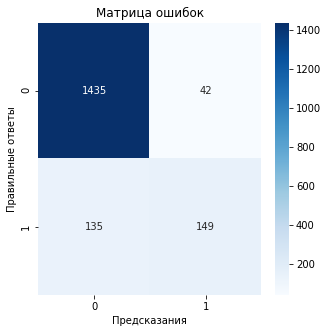

In [124]:
#матрица ошибок
c_matrix = confusion_matrix(b_target_test, best_model_prediction)
plt.figure(figsize=(5, 5))
sns.heatmap(c_matrix,
            annot=True,
            cmap='Blues',
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show()

Проведем анализ важности признаков модели.

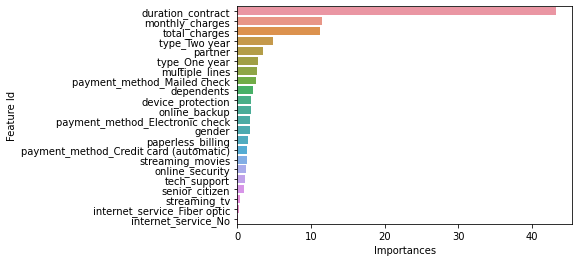

In [125]:
#анализ важности признаков
train_dataset = Pool(b_features_train_ohe, b_target_train)
feature_importance = best_model.get_feature_importance(train_dataset, prettified = True)
sns.barplot(y=feature_importance['Feature Id'], x=feature_importance['Importances']);

Посмотрим на Roc-кривую итоговой модели.

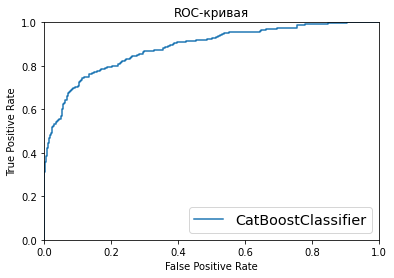

In [126]:
fpr, tpr, thresholds = roc_curve(b_target_test, best_model_prediction_proba)
plt.plot(fpr, tpr, label='CatBoostClassifier')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Видно, что на решение об уходе клиента из компании влияет срок действия договора в основном(duration_contract). Последующие признаки: месячные траты (monthly_charges), общие траты (total_charges), тип договора (type_two_year), наличие супруга(и)(partner) и так далее.

### Выводы:

Исследование данных

* все таблицы просмотрены и объединены в общий датасет data
* все названия столбцов приведены к змеиному стилю
* значения столбцов **begin_date** и **end_date** приведены к типу datetime
* значения столбцов **monthly_charges** и **total_charges** приведены к типу float
* пропуски в поле **total_charges** заменены на значения из **monthly_charges**
* No в **end_date** заменены на дату выгрузки 2020.02.01
* все пропуски после объединения заполнены заглушками категориального типа 0-1
* все значения переведены к 0-1

Анализ данных

почти 60% клиентов получают счет по электронной почте
* 16% пенсионеров, 48% имеют партнера, почти 30% имеют иждивенцев
* 28,6% используют блокировку опасных сайтов(online_security), 34,5% используют облачное хранилище(online_backup), 34,4% пользуются антивирусом(device_protection), 29% используют выделенную линию техподдержки(tech_support), 38,8% используют стриминговое телевидение(streaming_tv), 38,4% пользуются каталогом фильмов(streaming_movies), 42% используют параллельные вызовы во время разговора(multiple_lines)
* телефонной линией пользуются 34,3%, оптоволокном 43,9%
* почти 21% пользуются годичным договором, 24% двугодичным
* 21,6% оплачивают кредиткой, 22,8% чек по почте, 33,5% электронным чеком
* равное количество мужчин и женщин
* расторгло договор с компанией около 15,6% клиентов

* Begin_date. Виден пик в районе 2014 года, после стабильный уровень до начала 2019 года, высокий прирост в 2019-2020. Спад в конце обусловлен ограничением данных датой 2020-02-01. В основном ушли клиенты, заключившие договора в 2014 году (более 300 человек), ближе к концу 2019 года их все меньше
* End_date. Первый пик ухода приходится на конец 2014- начало 2015 года, второй пик почти в конце 2016 года, третий пик в середине 2017, к концу 2017- началу 2018 года наблюдается минимальный уход клиентов, но под конец 2018 снова возрастание. Можно наблюдать тенденцию к уходу клиентов ближе ко второй половине года- концу. Большая часть ушедших клиентов имела срок окончания договора 2017-2020 года.
* Счет выставляется по почте более чем 4000 клиентов, почти 3000 используют иной способ. Ушли в основном клиенты, использующие эту услугу.
* в основном (более 1500) клиенты тратятся не слишком много, основной блок клиентов составляет от 70-120. Ушли клиенты в основном с тратами от 90-110, а так же 10-30 в месяц
* наибольшее количество клиентов с наименьшими тратами(почти 3000), наименьшее с наибольшими(до 100). Ушли клиенты в основном с общими тратами 1000-4000, наименьшее количество ушо с тратами 6800-7700.
* Пенсионеров 1142, не пенсионеров 5901. В основном ушли не пенсионеры (более 800).
* большая часть живет без иждивенцев 4953, с ними 2110. Ушли в основном люди без иждивенцев(более 700).
* Услугой **online_security** (блокировка небезопасных сайтов) пользуется 2019 человек против 5024. Ушедшие клиенты в основом не пользовались услугой (более 600).
* Услугой **online_backup** (Облачное хранилище файлов для резервного копирования данных) пользуется 2429 против 4614. Ушло клиентов, пользующихся в равной степени услугой.
* Услугой **device_protection** (антивирус) пользуются 2422 против 4621. Ушло равное количество клиентов, пользующихся услугой.
* Услугой **tech_support** (Выделенная линия технической поддержки) пользуются 2044 против 4999. Ушедшие клиенты в основном не пользовались данной услугой (400 человек против 700)
* Услугой **streaming_movies** (каталог фильмов) пользуются 2732 против 4311. Ушедшие клиенты пользовались данной услугой практически в равной степени (чуть более 600 против почти 500)
* Услугой **multiple_lines** (несколько линий) пользуются 2971 против 4072. Ушедшие клиенты в основном пользовались данной услугой (почти 700 против чуть более 400)
* Клиенты больше всего используют помесечный тип договора 3875, потом 2-годичный 1695 и 1-годичный 1473. В основном ушли клиенты с помесячной оплатой (чуть более 400), 2-летней (почти 400) и 1-летней (чуть более 300)
* Больше всего клиенты пользуются оптоволокном 3096, потом телефонной линией 2421, а 1526 вообще не пользуются услугой. Большая часть ушла клиентов оптоволокна( почти 600), телефонной линии(более 300), не пользовались услугой почти 200 ушедших.
* По типу платежа следующее распределение: Electronic check 2365, Mailed check 1612, Bank transfer (automatic) 1544, Credit card (automatic) 1522. В основном ушли Electronic check 350, Bank и Credit Card 320, Mailed check 120
* По половой принадлежности распределение практически одинаковое. 3555 мужчин против 3488 женщин. Ушли практически в равной степени клиенты мужского(почти 600) и женского(чуть более 500) пола.
* Ушедших клиентов небольшое количество 1101 против 5942 оставшихся
* В основном ушедшие клиенты пользовались услугами компании от 500-1500 дней.

Подготовка к обучению

* Были убраны из набора данных конфликтующие столбцы end_date, begin_date с duration_contract
* Был найден дисбаланс целевого признака
* Основная часть данных имеет минимальную зависимость. Сильная зависимость у duration_contract и total_charges. Чем дольше клиент пользуется услугами тем больше денег он тратит.
* переведены бинарные категориальные переменные к значениям 1 и 0
* Для оставшихся признаков был применен метод OHE
* Данные были поделены на train и test(0.25).

Обучение моделей

Обучены модели:
* CatBoostClassifier
* RandomForestClassifier
* LogisticRegression

Получены следующие результаты:
* CatBoostClassifier ('depth': 6, 'iterations': 70, 'learning_rate': 0.5, random_state=30723) показал ROC-AUC = 0.8662070945579403
* RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=200, random_state=30723) показал ROC-AUC = 0.8265186323741995.
* LogisticRegression(max_iter=10, penalty='l1', random_state=30723, solver='liblinear'') показал ROC-AUC = 0.6500381104310525.

Лучшей моделью признана:
* **CatBoostClassifier**

Тестирование лучшей модели

**CatBoostClassifier ('depth': 6, 'iterations': 70, 'learning_rate': 0.5, random_state=30723)**

* Показатель лучшей модели: 0.8850377144382886. По условию значение ROC-AUC должно быть >=0.85. Условие выполнено. Модель успешна.
* Создана матрица ошибок
* Из анализа признаков: видно, что на решение об уходе клиента из компании влияет срок действия договора в основном(duration_contract). Последующие признаки: месячные траты (monthly_charges), общие траты (total_charges), тип договора (type_two_year), наличие супруга(и)(partner) и так далее.